# 551 Lec 5 - Dash-R and ggplotly

## Lecture learning goals

By the end of the lecture you will be able to:

1. Run a Dash-R app on a local server
2. Create Dash html and widgets (dropdowns, sliders, etc) in R
3. Implement callbacks with multiple input and outputs in R
4. Use dash bootstrap components to lay out dashboard components on grid in R
5. Convert ggplot objects into interactive plotly javascript specs
6. Link plotly plots to callbacks and capture emitted server side signals

-------------

Install dash via https://dashr.plotly.com/installation
and the latest version of dash bootstrap via https://dash-bootstrap-components.opensource.faculty.ai/docs/dashr/.

In short:

```r
# Installs dashHtmlComponents, dashCoreComponents, and dashTable
# and will update the component libraries when a new package is released
install.packages('dash')

# Installs dash bootstrap
library(devtools)
install_github('facultyai/dash-bootstrap-components@r-release')
```

The dashr docs are similar to the Python ones and can be found at https://dashr.plotly.com.
For dash bootstrap, there is currently no separate documentation,
the R components work the same as the Python ones with the same arguments.

As a refresher,
our skeleton looked like this for Python:

```python
import dash
import dash_html_components as html


app = dash.Dash()
app.layout = html.Div('I am alive!!')
app.run_server()
```

The equivalent in R is this:

```r
library(dash)
library(dashHtmlComponents)

app = Dash$new()

app$layout(htmlDiv('I am alive!!'))

app$run_server(debug = T)
```

![](images/5/5.01.png)

Note that `debug` does not work as well in R as in Dash for Python.
Sometimes you still need to refresh the page to see the update,
or even restart the server.
`debug` also hides some error messages, 
which is not very helpful,
and you might need to run without it to discover what is actually going wrong with your app.

To run this app,
we either click `source` in RStudio
or run `Rscript app.R` from the command line.

You can see that it is very similar between the two languages.
The most common changes in:

- Instead of `.`, R sometimes uses `$` and sometimes just omits the `.`.
- The initialization of the `Dash` instance looks slightly different.
- app$layout is a function
- Instead of `[]`, we use `list()`
- Instead of dictionaries, we use named lists.

A few examples:

| Python              | R                   |
|---------------------|---------------------|
| `app = dash.Dash()` | `app <- Dash$new()` |
| `app.layout = ...`  | `app$layout(...)`   |
| `app.run_server()`  | `app$run_server()`  |
| `html.Div`          | `htmlDiv`           |
| `html.H1`           | `htmlH1`            |
| `dcc.Dropdown`      | `dccDropdown`       |
| `python app.py`     | `Rscript app.R`     |

Let's see a slightly more involved example including a stylesheet,
headings, and style configuration.

```r
library(dash)
library(dashHtmlComponents)

app = Dash$new(external_stylesheets = "https://codepen.io/chriddyp/pen/bWLwgP.css")

app$layout(
    htmlDiv(
        htmlH1('I am alive!!',
               style=list('color' = 'cyan', 'background-color' = '#000000')
               )
        )
    )

app$run_server(debug = T)
```

![](images/5/5.02.png)

In [1]:
scatter_by <- function(data, x, y) {
  x <- as.name(x)
  y <- enquo(y)

  ggplot(data) + geom_point(aes(!!x, !!y))
}
scatter_by(mtcars, 'disp', drat)

ERROR: Error in enquo(y): could not find function "enquo"


## Widgets

Lets see what an app looks like with widgets

```r
library(dash)
library(dashCoreComponents)
library(dashHtmlComponents)

app <- Dash$new(external_stylesheets = "https://codepen.io/chriddyp/pen/bWLwgP.css")

app$layout(
    htmlDiv(
        list(
            dccDropdown(
                options = list(list(label = "New York City", value = "NYC"),
                               list(label = "Montreal", value = "MTL"),
                               list(label = "San Francisco", value = "SF")),
                value = 'MTL'
            )
        )
    )
)

app$run_server(debug = T)
```

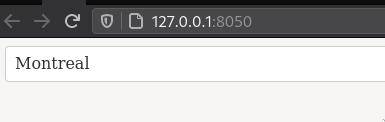
![](images/5/5.03.png)

In Python we used a list of dictionaries for the `options`,
the equivalent in R is a list of named lists.
For multiselect we would change `value = 'MTL'` to `value = list('MTL', 'SF'), multi=TRUE`.
You could also use a vector instead of a list for the values here
(and some other places where dash just needs any array),
but I will stick to lists as in the docs.
Watch out for trailing commas after parentheses (`),`).
This is fine in Python list,
but R will raise the error `argument X is empty from list()`

To add a html label,
there is a small difference,
in that it is just stacked on top of the dropdown
(instead of passing a list with the string and dropdown to the label function):

```r
list(
    htmlLabel('Dropdown'),
    dccDropdown(...)
    )
```

There is a small gotcha with sliders,
in that the suggested way to add marks in the docs,
does not work when running the server in debug mode.
Instead you can use a named list like this:

```r
library(dash)
library(dashCoreComponents)
library(dashHtmlComponents)

app <- Dash$new(external_stylesheets = "https://codepen.io/chriddyp/pen/bWLwgP.css")

app$layout(
    htmlDiv(
        list(
            htmlLabel('Slider'),
            dccSlider(
                min = 1,
                max = 10,
                marks = list(
                    "1" = "1°C",
                    "5" = "5°C",
                    "10" = "10°C"
                ),
                value = 5
            )
            
        )
    )
)

app$run_server(debug = T)
```

![](images/5/5.04.png)

<!--
% TODO
% If we automatically wanted to generate
-->

## Callbacks

R does not have function decorators,
which is what we used to link widgets to functions 
via callback in Python.
Remember that a decorator in Python is only a syntax shortcut
to wrapping a function in another function,
which is what we will do in R
passing both the outputs, inputs, and callback function
as parameters.

```r
library(dash)
library(dashCoreComponents)
library(dashHtmlComponents)

app <- Dash$new(external_stylesheets = "https://codepen.io/chriddyp/pen/bWLwgP.css")

app$layout(
    htmlDiv(
        list(
            dccInput(id='widget-1'),
            htmlDiv(id='widget-2')
        )
    )
)

app$callback(
    list(output('widget-2', 'children')),
    list(input('widget-1', 'value')),
    function(input_value) {
        return(list(input_value))  # Would also work without `return()`
    })

app$run_server(debug = T)
```

![](images/5/5.05.png)

Note that you don't need explicit return statements in R,
as the last value of the functions is always returned,
I just added it here for clarity.
When there is a single output,
we could skip the list both in the callback and the function return statement.
But for single inputs,
we still need a list:

```r
app$callback(
    output('widget-2', 'children'),
    list(input('widget-1', 'value')),
    function(input_value) {
        return(input_value)
    })
```

### Multiple input/outputs

For multiple input and outputs,
we need to pass a list of `input()`/`output()` functions.


```r
library(dash)
library(dashCoreComponents)
library(dashHtmlComponents)

app <- Dash$new(external_stylesheets = "https://codepen.io/chriddyp/pen/bWLwgP.css")

app$layout(
    htmlDiv(
        list(
            dccInput(id='widget-1'),
            dccInput(id='widget-4'),
            htmlDiv(id='widget-2'),
            htmlDiv(id='widget-3')
        )
    )
)

app$callback(
    list(output('widget-2', 'children'),
         output('widget-3', 'children')),
    list(input('widget-1', 'value'),
         input('widget-4', 'value')),
    function(input_value, input_value2) {
        return(list(input_value, input_value2))
    })

app$run_server(debug = T)
```

![](images/5/5.06.png)

## Dashbootstrap

For dashbootstrap,
the R components work the same as the Python ones with the same arguments.
You 

```text
library(dash)
library(dashCoreComponents)
library(dashHtmlComponents)
library(dashBootstrapComponents)

app <- Dash$new(external_stylesheets = dbcThemes$BOOTSTRAP)

app$layout(
    dbcContainer(
        dbcRow(
            list(
                dbcCol(
                    list(
                        htmlLabel('Left'),
                        dccDropdown(
                            options = list(list(label = "New York City", value = "NYC"),
                                           list(label = "San Francisco", value = "SF")),
                            value = 'NYC'
                        )
                    )
                ),
                dbcCol(
                    list(
                        htmlLabel('Right'),
                        dccDropdown(
                            options = list(list(label = "New York City", value = "NYC"),
                                           list(label = "San Francisco", value = "SF")),
                            value = 'SF'
                        )
                    )
                )
            )
        ), style = list('max-width' = '85%')  # Change left/right whitespace for the container
    )
)

app$run_server(debug = T)
```

## Creating interactive ggplots with the help of plotly

To leverage the power of `ggplot` for interactive graphs and make it work well with `dash`,
the creators of `plotly` wrote a wrapper function called `ggplotly()`
that looks at the structure of a `ggplot` figure
and converts it into a plotly javascript figure.
This s quite convenient,
as we don't need to learn a separate package for interactivity,
we just need to remember this function
and later also learn some special parts of it for linking plots together etc.

Let's see what a simple example might look like with a built-in data set of mammalian sleeping patterns.

In [ ]:
library(ggplot2)

head(msleep)

Do heavy animals sleep more?

In [ ]:
p <- ggplot(msleep) +
    aes(x = bodywt,
        y = sleep_total) +
  geom_point()
p 

Lets log the x-axis so it is easier to see

In [ ]:
p <- ggplot(msleep) +
    aes(x = bodywt,
        y = sleep_total) +
  geom_point() +
  scale_x_log10()
p 

How do we make this ggplot interactive?
First `install.packages("plotly")`.
This provides the function `ggplotly` which can wrap a ggplot object
([all plotly compatible geoms can be found here](https://plotly.com/ggplot2/)).

In [ ]:
library(plotly)

ggplotly(p)

Similar to Altair,
you have some interactive controls in the modebar to the top left,
save as png, zoom, pan, etc (double click to reset a view, or click "home").
The default is to span the entire width,
which is often what we want in a dashboard where the columns already control the width,
but can be a bit annoying in the notebook so lets make it more narrow.
You can [read here how to configure the modebar](https://plotly-r.com/control-modebar.html).

In [ ]:
# Might not work in Jupyter
ggplotly(p, width = 100)

Let's color by animal diet to see it that can further explain this relationship.

In [ ]:
p <- p + aes(color = vore)
ggplotly(p)

The legend is clickable by default,
which is really nice!
Double click to select only one.

Any styling we create in ggplot carries over to plotly.

In [ ]:
p <- p +
    theme_classic() +
    ggthemes::scale_color_tableau()
ggplotly(p)

However, all the interactive functionality is from plotly.
Here it would be nice with a tooltip to see which animal is which.

In [ ]:
ggplotly(p, tooltip = 'name')

Why didn't this work?
`ggplotly` does not see the underlying dataset,
just the ggplot object,
so we must make sure that everything we want to use is bound somewhere by ggplot.
We can set it to the text aesthetic which wil not show up by default inside the scatter plot,
but can be reached from `ggplotly` since it is now part of the ggplot specification.

In [ ]:
ggplotly(p + aes(text = name), tooltip = 'name')

This is a good example of where a tooltip is really useful,
because we might be interested in which particular animal is at a certain place in this plot,
and there is no good way of doing that with static text or colors
without making the plot really busy.

We could also have referenced the aes binding we used,
instead of the column name.

In [ ]:
ggplotly(p + aes(text = name), tooltip = 'text')

## ggplotly + dash

To get these functions into dash,
we need to include both the ggplot part 
and the ggplotly part.

Since the `ggplotly` converts the plot into a nativ epotlfy obejct,
we don't have to use an iframe, 
but can instead use Dash's core component `dccGraph` for displaying the plot.

```r
library(dash)
library(dashCoreComponents)
library(ggplot2)
library(plotly)

app <- Dash$new()

p <- ggplot(msleep) +
    aes(x = bodywt,
        y = sleep_total) +
    geom_point() +
    scale_x_log10()
 
app$layout(dccGraph(figure=ggplotly(p)))
    
app$run_server(debug = T)
```

![](images/5/5.07.png)

As with Altair,
we ideally would define our plotting function under the layout,
so that it can be setup with the callback directly.
Let's
create a more complex app that includes a dropdown controlling what is plotted via a callback.
We will also add bootstrap and the other best practices we have discussed previously.


```r
library(dash)
library(dashCoreComponents)
library(dashHtmlComponents)
library(dashBootstrapComponents)
library(ggplot2)
library(plotly)

app <- Dash$new(external_stylesheets = dbcThemes$BOOTSTRAP)

app$layout(
    dbcContainer(
        list(
            dccGraph(id='plot-area'),
            dccDropdown(
                id='col-select',
                options = msleep %>%
                    colnames %>%
                    purrr::map(function(col) list(label = col, value = col)), 
                value='bodywt')
        )
    )
)

app$callback(
    output('plot-area', 'figure'),
    list(input('col-select', 'value')),
    function(xcol) {
        p <- ggplot(msleep) +
            aes(x = !!sym(xcol),
                y = sleep_total,
                color = vore,
                text = name) +
            geom_point() +
            scale_x_log10() +
            ggthemes::scale_color_tableau()
        ggplotly(p)
    }
)

app$run_server(debug = T)
```

![](images/5/5.08.png)

We're using `purrr::map` as the equivalent of the list expression in Python,
but the logic here is that we are mapping a function to each one of the columns
and returning a named list where the column name is both the `label` and `value`.
If we wanted to seleted e.g. only numeric columns instead,
we could do `msleep %>% select_if(is.numeric) %>% colnames`.
Since explicit return statements are not needed for functions in R,
the `ggplotly(p)` line is what will be returned and put into the `figure` property of `plot-area`.

The `!!sym()` part might look rather cryptic at first.
It is needed to pass a string as a column name to ggplot.
Remember that out dropdown returns a string value, e.g. `'bodywt'`,
but in ggplot we want pass column names unquoted, like so `bodywt`,
This is the conversation that happens when we do `!!sym('bodywt')`
and it makes ggplot understand that we are referring to a column in the dataframe with this name.

## Multiple subplots

Faceting can be done through ggplot via e.g. `facet_wrap(~vore)`.
The plots are linked with zooming, panning, etc.

![](images/5/5.09.png)

If we want to combine any plots into subplots,
we had to use `cowplot` before.
Here we will use the plotly subplot function directly on the plotly objects instead.

In [ ]:
p1 <- ggplot(msleep) +
    aes(x = bodywt,
        y = sleep_total,
        color = vore,) +
    geom_point() +
    scale_x_log10() +
    ggthemes::scale_color_tableau()

p2 <- ggplot(msleep) +
    aes(x=vore) +
    geom_bar(stat='count')

subplot(ggplotly(p1), ggplotly(p2))

In [ ]:
subplot(ggplotly(p1), ggplotly(p2), nrows = 2)

We can use layout to change the default interaction.

In [ ]:
subplot(ggplotly(p1), ggplotly(p2), nrows = 2) %>% layout(dragmode = 'select')

## Emitted signals

By default, plotly plots emit signals upon selection and hover,
that can work as input to other callbacks.
This is what we will use next lecture to link plots together,
but for now we will just briefly see how it works.
Since these events are server side,
you will be able to link plots together that weren't necessarily created together.

```r
library(dash)
library(dashCoreComponents)
library(dashHtmlComponents)
library(dashBootstrapComponents)
library(ggplot2)
library(plotly)

app <- Dash$new(external_stylesheets = dbcThemes$BOOTSTRAP)

app$layout(
    dbcContainer(
        list(
            dccGraph(id='plot-area'),
            htmlDiv(id='output-area'),
            htmlBr(),
            dccDropdown(
                id='col-select',
                options = msleep %>%
                    colnames %>%
                    purrr::map(function(col) list(label = col, value = col)), 
                value='bodywt')
        )
    )
)

app$callback(
    output('plot-area', 'figure'),
    list(input('col-select', 'value')),
    function(xcol) {
        p <- ggplot(msleep) +
            aes(x = !!sym(xcol),
                y = sleep_total,
                color = vore,
                text = name) +
            geom_point() +
            scale_x_log10() +
            ggthemes::scale_color_tableau()
        ggplotly(p) %>% layout(dragmode = 'select')
    }
)

app$callback(
    output('output-area', 'children'),
    list(input('plot-area', 'selectedData')),
    function(selected_data) {
        toString(selected_data)
    }
)

app$run_server(debug = T)
```

![](images/5/5.10.png)

We can also look at multiple events at the same time.

```r
library(dash)
library(dashCoreComponents)
library(dashHtmlComponents)
library(dashBootstrapComponents)
library(ggplot2)
library(plotly)

app <- Dash$new(external_stylesheets = dbcThemes$BOOTSTRAP)

app$layout(
    dbcContainer(
        list(
            dccGraph(id='plot-area'),
            htmlDiv(id='output-area'),
            htmlBr(),
            htmlDiv(id='output-area2'),
            htmlBr(),
            dccDropdown(
                id='col-select',
                options = msleep %>% colnames %>% purrr::map(function(col) list(label = col, value = col)),
                value='bodywt')
        )
    )
)

app$callback(
    output('plot-area', 'figure'),
    list(input('col-select', 'value')),
    function(xcol) {
        p <- ggplot(msleep) +
            aes(x = !!sym(xcol),
                y = sleep_total,
                color = vore,
                text = name) +
            geom_point() +
            scale_x_log10() +
            ggthemes::scale_color_tableau()
        ggplotly(p) %>% layout(dragmode = 'select')
    }
)

app$callback(
    list(output('output-area', 'children'),
         output('output-area2', 'children')),
    list(input('plot-area', 'selectedData'),
         input('plot-area', 'hoverData')),
    function(selected_data, hover_data) {
        list(toString(selected_data), toString(hover_data))
    }
)

app$run_server(debug = T)
```

![](images/5/5.11.png)

## Attribution

These lecture notes were prepared by Dr. Joel Ostblom, a post-doctoral teaching fellow in the UBC Vancouver MDS program.